In [1]:
import numpy as np
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps

from bluesky.utils import Msg

def grad_acc(
        detectors,
        signal,
        motor,
        initial_guess,
        step_size,
        llim,
        hlim,
        num=10,repeat=1,
        *, md=None):
    r"""
    plan: tune a motor using gradient accent in a single axis

    Parameters
    ----------
    detectors : Signal
        list of 'readable' objects
    signal : string
        detector field whose output is to maximize
    motor : object
        any 'settable' object (motor, temp controller, etc.)
    initial_guess : 
        The initial guess for the position of motor to get the maximum from signal
    step_size : float
        The multiplier used in the gradient accent method
    num : int, optional
        The maximum number of itteration
    repeat : int, optional
        Whether to repeat readings to determine an average. Useful if your signal is noisy
    md : dict, optional
        metadata

    Examples
    --------
    Find the center of a peak using synthetic hardware.

    >>> from ophyd.sim import SynAxis, SynGauss
    >>> motor = SynAxis(name='motor')
    >>> det = SynGauss(name='det', motor, 'motor',
    ...                center=-1.3, Imax=1e5, sigma=0.05, noise="uniform",noise_multiplier=5e-5))
    >>> RE(grad_acc([det], "det", motor, -1.37, 0.00000001,num=2000,repeat=4)
    """
    
    try:
        motor_name, = motor.hints['fields']
    except (AttributeError, ValueError):
        motor_name = motor.name
    _md = {'detectors': [det.name for det in detectors],
           'motors': [motor.name],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motor': repr(motor),
                         'initial_guess': initial_guess,
                         'step_size': step_size,
                         'max_num': num,
                         'repeat': repeat
                         },
           'plan_name': 'grad_acc',
           'hints': {},
           }
    _md.update(md or {})
    try:
        dimensions = [(motor.hints['fields'], 'primary')]
    except (AttributeError, KeyError):
        pass
    else:
        _md['hints'].setdefault('dimensions', dimensions)


    @bpp.stage_decorator(list(detectors) + [motor])
    @bpp.run_decorator(md=_md)
    def _tune_core(initial_guess, step_size, num, signal):

        #Take a step in one direction
        i = 0
        gradient = 0.001
        next_pos = initial_guess
        previous_x = initial_guess
        
        yield from bps.mv(motor, next_pos)
        yield Msg('checkpoint')

        #Read the new values and determine the gradient
        ret = []
        y_sum = 0
        for j in range(repeat):
            ret = ((yield from bps.trigger_and_read(detectors + [motor])))
            y_sum =+ ret[signal]['value']

        current_y = y_sum/repeat

        while i<num and gradient>0.00001 and next_pos<hlim and next_pos>llim:

            #Stash the previous values
            previous_x = next_pos

            previous_y = current_y
            

            #Determine next position
            next_pos = previous_x + step_size*gradient

            #Move to the new position
            yield from bps.mv(motor, next_pos)

            #Read the new values and determine the gradient
            ret = []
            y_sum = 0
            for j in range(repeat):
                ret = ((yield from bps.trigger_and_read(detectors + [motor])))
                y_sum =+ ret[signal]['value']

            current_y = y_sum/repeat

            #Determine the gradient between the previous position and the new position
            delta_x = next_pos-previous_x
            delta_y = current_y - previous_y
            gradient = delta_y/delta_x

            print(f"x: {next_pos},gradient:{gradient}")
            i = i+1

        print(f"Gradient is {gradient}, moving back to previous position {previous_x}")
        yield from bps.mv(motor, previous_x)

    return (yield from _tune_core(initial_guess, step_size, num, signal))



x: -1.3099999900000001,gradient:999.9508681011519
x: -1.3000004813189885,gradient:500.01106559285165
x: -1.29500037066306,gradient:-249.95583890248648
Gradient is -249.95583890248648, moving back to previous position -1.3000004813189885


('1a10e2fa-ca1b-4578-ace2-e0a8998d269e',)

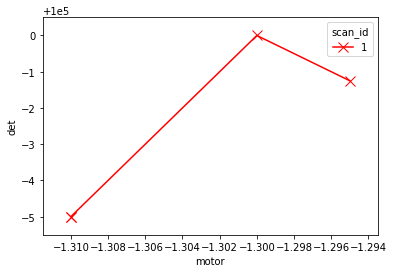

In [3]:
from ophyd.sim import SynAxis, SynGauss
motor = SynAxis(name='motor')
det = SynGauss(name='det', motor=motor, motor_field='motor', center=-1.3, Imax=1e5)#, sigma=0.5, noise="uniform",noise_multiplier=1e-5)


from bluesky import RunEngine

RE=RunEngine({})
#Set up plotting
from bluesky.callbacks.best_effort import BestEffortCallback
from event_model import RunRouter

from bluesky.callbacks.mpl_plotting import LivePlot


RE(grad_acc([det], "det", motor, -1.31, 0.00001,hlim=-1.29,llim=-1.32,num=2000,repeat=1),LivePlot('det', 'motor',marker='x', markersize=10, color='red'))